# Setup

In [0]:
%%capture
%pip install poetry
%pip install git+https://github.com/oughtinc/ergo.git@plot-feature
%pip install xlrd

In [33]:
%load_ext google.colab.data_table

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [0]:
%%capture
import ergo
import numpy as np
import pandas as pd
import ssl
import math
import datetime
import warnings
import functools
import seaborn
import sklearn

from datetime import timedelta, date

In [0]:
warnings.filterwarnings(module="plotnine", action="ignore")
warnings.filterwarnings(module="jax", action="ignore")
ssl._create_default_https_context = ssl._create_unverified_context

In [0]:
metaculus = ergo.Metaculus(
    username="oughtpublic", 
    password="123456",
    api_domain = "pandemic"
)

# Ergo extensions

We'll define some helper functions that might get moved into Ergo in the future.

In [0]:
START_DATE = date(2020, 4, 1)


def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)


# Memoization

memoized_functions = []

def mem(func):
    func = functools.lru_cache(None)(func)
    memoized_functions.append(func)
    return func

def clear_mem():
    for func in memoized_functions:
        func.cache_clear()

# Associate models with questions

samplers = {}

def question(question_id, community_weight=0):
    q = metaculus.get_question(question_id)

    def decorator(func):
        tag = func.__name__

        @functools.wraps(func)
        @mem
        def sampler():
            if ergo.flip(community_weight):
                value = q.sample_community()
            else:
                value = func()
            if isinstance(value, date):
                # FIXME: Ergo needs to handle dates
                ergo.tag(int((value - START_DATE).days), tag)
            else:
                ergo.tag(value, tag)
            return value
        sampler.question = q
        samplers[q.id] = sampler
        return sampler
    return decorator

def summarize_question_samples(samples):
    sampler_tags = [sampler.__name__ for sampler in samplers.values()]
    tags_to_show = [tag for tag in sampler_tags if tag in samples.columns]
    samples_to_show = samples[tags_to_show]
    summary = samples_to_show.describe().transpose().round(2)
    display(summary)

def plot_question(sampler, num_samples=200):
  def model():
      clear_mem()
      sampler()

  samples = ergo.run(model, num_samples=num_samples)

  summarize_question_samples(samples)

  q = sampler.question

  q_samples = samples[sampler.__name__]

  if q.id == 4128: # Date question: Need to convert back to date from days (https://github.com/oughtinc/ergo/issues/144)
      q_samples = np.array([START_DATE + timedelta(s) for s in q_samples])

  q.show_prediction(samples=q_samples, show_community=True, percent_kept=0.9)

# External data (cases, estimates, models)

## Texas government cases data

In [38]:
texas_cases = pd.read_excel("https://dshs.texas.gov/coronavirus/TexasCOVID19DailyCountyCaseCountData.xlsx")
texas_cases.columns = texas_cases.iloc[1]

el_paso_cases = (texas_cases.loc[texas_cases["County Name"] == "El Paso"]
                 .drop(columns=["County Name", "Population"])
                 .transpose())

el_paso_cases.columns = ["Cases so far"]

def get_date(column_name):
  date_str = column_name.split("\n")[1]
  month_str, day_str = date_str.split("-")
  return date(2020, int(month_str), int(day_str))

el_paso_cases.index = [get_date(id) for id in el_paso_cases.index]

el_paso_cases["New cases"] = el_paso_cases["Cases so far"].diff()

el_paso_cases.tail()

,Cases so far,New cases
2020-04-25,706,32
2020-04-26,780,74
2020-04-27,802,22
2020-04-28,829,27
2020-04-29,857,28


## @onlyasith's cases model



From [this](https://pandemic.metaculus.com/questions/4128/when-will-el-paso-county-texas-experience-its-first-peak-number-of-covid-infections/#comment-28304) comment. We made a copy of the model [here](https://docs.google.com/spreadsheets/d/119xLDClNoSIR0xe_svjXz44yjPj9wXyc_WZPiHHn3ac/edit#gid=1213113172).

In [39]:
projected_cases = pd.read_csv(
    "https://docs.google.com/spreadsheets/d/e/2PACX-1vSurcOWEsa7DBCRfONFA2Gxf802Rj1FebYSyVzvACysenRcD79Fs0ykXWJakIhGcW48_ymgw35TKga-/pub?gid=1213113172&single=true&output=csv",
    index_col="Date",
    parse_dates=True,
)

projected_cases = projected_cases.dropna()
projected_cases["Cases so far"] = projected_cases["Cases so far"].apply(lambda str: int(str.replace(",", "")))
projected_cases["New cases"] = projected_cases["Cases so far"].diff()

projected_cases

,Cases so far,New cases
Date,,
2020-04-04,96,NaN
2020-04-05,106,10.0
2020-04-06,115,9.0
2020-04-07,125,10.0
2020-04-08,153,28.0
...,...,...
2020-09-30,1090,0.0
2020-10-01,1090,0.0
2020-10-02,1091,1.0


## @KrisMoore's compiled data

[This](https://docs.google.com/spreadsheets/d/1MgRZd0iYZCIgQ8KfRJJTnNrdvUfa2KvBHPA5QVjtFnk/edit#gid=0) sheet, copied [here](https://docs.google.com/spreadsheets/d/1D3Slkrj3sz2VkD2CZ61GOxTj5SaFyn5Nkuczaj_WXqE/edit#gid=0).

In [40]:
compiled_data = pd.read_csv(
    "https://docs.google.com/spreadsheets/d/e/2PACX-1vQEZk_8wZMF5MEm_f66wpev4nkWP7edQ8l6SwcbUd68zFZw6EVizh-jplw2_9gZBGyhNaJk5R_CG25k/pub?gid=0&single=true&output=csv",
    index_col="date",
    parse_dates=True,
)
compiled_data = compiled_data.rename(columns={"in_hospital": "In hospital confirmed"})

compiled_data

,cases,new_cases,2_day_sma_new_cases,presumed_active_cases,fatalities,recovered,In hospital confirmed,in_icu,on_ventilator,tests_el_paso_dpt_public_health_only,new_tests_el_paso_dpt_public_health_only,tests_el_paso_inc_other_labs,tests_texas_all_sources,population
date,,,,,,,,,,,,,,
2020-03-04,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"952,366"
2020-03-05,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-06,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-07,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-08,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## @brachbach regression model (cases -> hospitalized)

In [0]:
@mem
def hospital_stay_days():
    hospital_stay_days_point_estimate = 7

    hospital_stay_days_fuzzed = round(
        float(ergo.normal_from_interval(
            hospital_stay_days_point_estimate * 0.5,
            hospital_stay_days_point_estimate * 1.5
        ))
    )

    return max(1, hospital_stay_days_fuzzed)


@mem
def get_hospital_confirmed_from_daily_infected_model(daily_infections):    
    # from https://penn-chime.phl.io/

    has_hospital_confirmed = compiled_data[compiled_data["In hospital confirmed"].notna()]

    data_dates = has_hospital_confirmed.index

    # for each date for which we have data for how many lab-confirmed COVID patients were in the hospital,
    # how many new confirmed cases were there over the past hospital_stay_days days?
    def get_recent_infected_data(date):
      return sum([daily_infections(date - timedelta(n))
        for n in range(0, hospital_stay_days())])

    recent_infected_data = [[get_recent_infected_data(date)]
      for date in data_dates]

    reg = sklearn.linear_model.LinearRegression(fit_intercept=False).fit(
        recent_infected_data,
        has_hospital_confirmed["In hospital confirmed"])

    # TODO: consider adding uncertainty to the fit here

    # now that we've related current hospitalized cases and recent confirmed cases,
    # return a function that allows us to predict hospitalized cases given estimates
    # of future confirmed cases
    def hospital_confirmed_from_daily_infected_model(date: date):
      recent_infected = sum([daily_infections(date - timedelta(n))
        for n in range(0, hospital_stay_days())])
      return round(reg.predict([[recent_infected]])[0])
  
    return hospital_confirmed_from_daily_infected_model

# Model components

In [0]:
@mem
def daily_infections(date: date) -> int:
    """
    What is the number of reported (new) Covid-19 infections on [date]?
    """
    try:
        # Look up Texas Government data
        new_cases = el_paso_cases.loc[date, "New cases"]
        if np.isnan(new_cases):
            raise KeyError
        return new_cases
    except KeyError:
        try:
            # Look up projections from @onlyasith's model
            cases = projected_cases.loc[date, "New cases"]
            if np.isnan(cases):
                raise KeyError
            
            # Add some (fairly arbitrary) uncertainty around this point estimate
            if cases == 0:
              return cases
            cases_estimate = ergo.lognormal_from_interval(cases * 0.8, cases * 1.2)
            return np.clip(cases_estimate, cases * 0.5, cases * 2)
        except KeyError:
            # We're beyond the time range for data and model
            return 0

@mem
def mean_infections(start_date: date, end_date: date):
    """
    What is the average number of reported new infections for this range of 
    dates? (Including start date, excluding end date)
    """
    days = daterange(start_date, end_date)
    return np.mean([daily_infections(day) for day in days])

# Build @brachbach regression model
hospital_confirmed_from_daily_infected_model = get_hospital_confirmed_from_daily_infected_model(daily_infections)

@mem
def hospital_confirmed_for_date(date: date) -> int:
    """
    The total number of lab-confirmed COVID-19 patients in El Paso County in
    the hospital on this date
    """
    try:
        # Look up in-hospital confirmed cases from @KrisMoore's compiled data
        new_hospital_confirmed = compiled_data.loc[date, "In hospital confirmed"]
        if np.isnan(new_hospital_confirmed):
            raise KeyError
        return new_hospital_confirmed
    except KeyError:
        try:
            # Get point estimate from @brachbach's regression model
            cases = hospital_confirmed_from_daily_infected_model(date)
            
            # Add some (fairly arbitrary) uncertainty around this point estimate
            if cases == 0:
              return cases
            cases_estimate = ergo.lognormal_from_interval(cases * 0.8, cases * 1.2)
            return np.clip(cases_estimate, cases * 0.5, cases * 2)
        except KeyError:
            return 0

@mem
def frac_icu_ventilation():
    """
    Proportion of ICU admissions requiring ventilation

    Approach (PabloStafforini et al): 
    https://pandemic.metaculus.com/questions/4154/#comment-28155

    TODO: 
    - Improve how we use case data
    - Add qualitative adjustments
    """
    ventilation_pseudocounts = 25 + 17 + 0.05 * 1150 + 0.1 * 132
    icu_pseudocounts = 100 + 36 + 0.05 * 1300 + 0.1 * 196
    return ergo.beta_from_hits(ventilation_pseudocounts, icu_pseudocounts)

# El Paso questions

,count,mean,std,min,25%,50%,75%,max
peak_infection_date,200.0,25.35,5.82,14.0,25.0,25.0,25.0,64.0


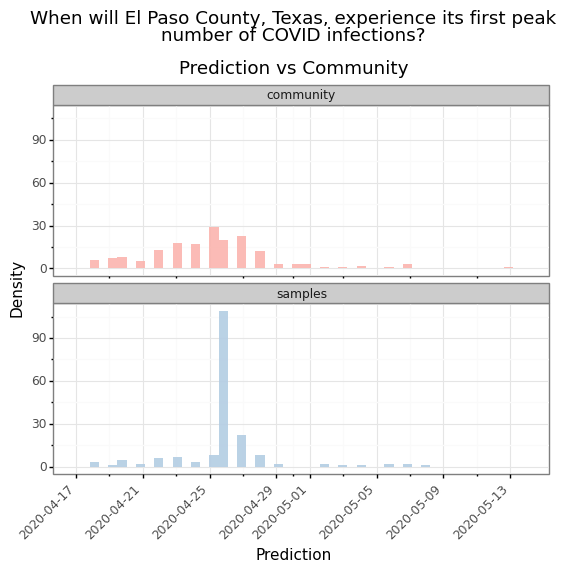

In [43]:
@question(4128, community_weight=0.5)
def peak_infection_date() -> date:
    """
    When will El Paso County, Texas, experience its first peak number of COVID
    infections?
    """    
    end_date = date(2020, 7, 1)
    for today in daterange(START_DATE, end_date):
        yesterday = today - timedelta(1)
        tomorrow = today + timedelta(1)
        two_day_mean = mean_infections(yesterday, tomorrow)
        future_means = [mean_infections(today + timedelta(i), today + timedelta(i+2)) for i in range(10)]
        if two_day_mean > max(future_means):
            return today
    return end_date
plot_question(peak_infection_date)

,count,mean,std,min,25%,50%,75%,max
peak_infection_date,104.0,24.89,4.77,14.0,24.00,25.00,25.0,61.00
peak_infections,200.0,106.77,485.19,0.0,38.98,65.93,74.0,4932.47


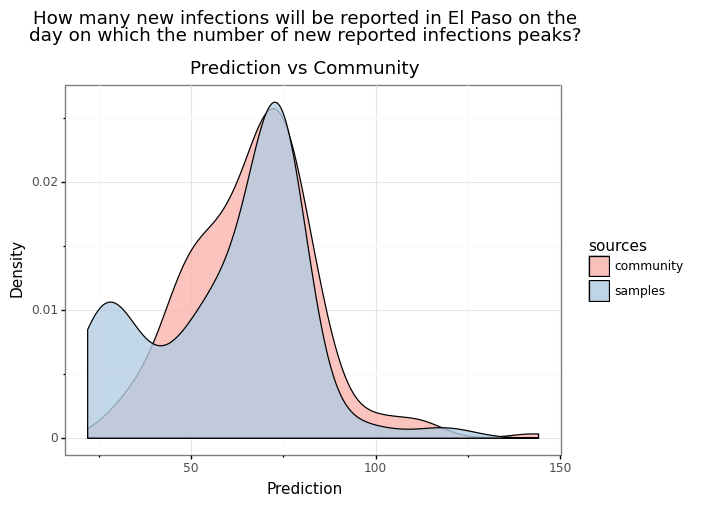

In [44]:
@question(4137, community_weight=0.5)
def peak_infections():
    """
    How many new infections will be reported in El Paso on the day on which
    the number of new reported infections peaks?
    """
    peak = peak_infection_date()
    return daily_infections(peak)
plot_question(peak_infections)

,count,mean,std,min,25%,50%,75%,max
peak_infection_date,89.0,25.67,13.19,14.00,24.00,25.00,25.00,138.0
mean_infections_peak345,200.0,41.37,217.10,0.62,22.18,24.72,29.19,3094.1


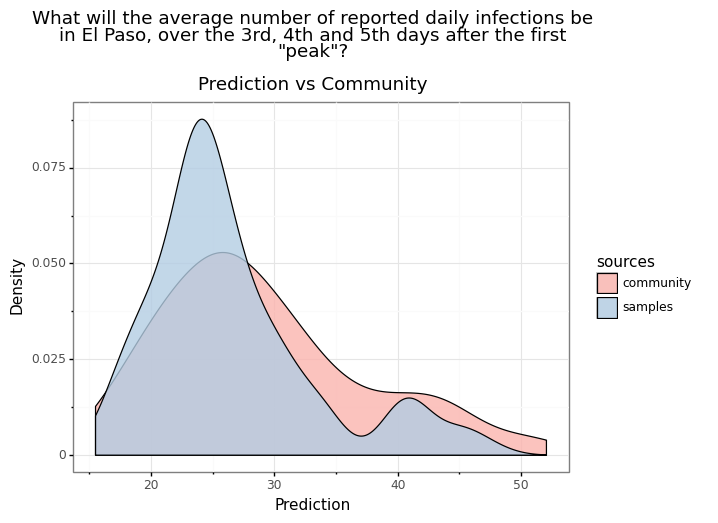

In [45]:
@question(4152, community_weight=0.5)
def mean_infections_peak345():
    """
    What will the average number of reported daily infections be in El Paso,
    over the 3rd, 4th and 5th days after the first "peak"?
    """
    peak = peak_infection_date()
    return mean_infections(peak + timedelta(3), peak + timedelta(6))
plot_question(mean_infections_peak345)

,count,mean,std,min,25%,50%,75%,max
peak_infection_date,34.0,26.68,9.30,19.0,24.00,25.00,25.00,72.00
mean_infections_peak678,200.0,61.10,361.17,0.0,16.95,24.09,34.42,4588.51


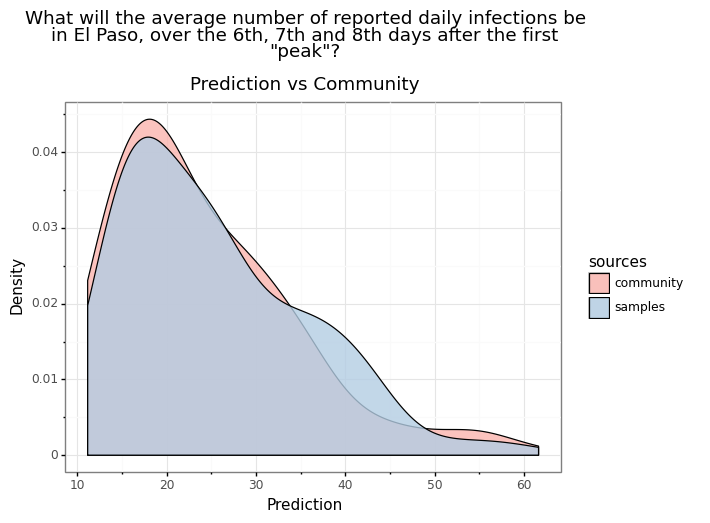

In [46]:

@question(4170, community_weight=0.8)
def mean_infections_peak678():
    """
    What will the average number of reported daily infections be in El Paso,
    over the 6th, 7th and 8th days after the first "peak"?  
    """
    peak = peak_infection_date()
    return mean_infections(peak + timedelta(6), peak + timedelta(9))
plot_question(mean_infections_peak678)

,count,mean,std,min,25%,50%,75%,max
frac_patients_icu,200.0,0.31,0.11,0.08,0.24,0.3,0.36,0.98


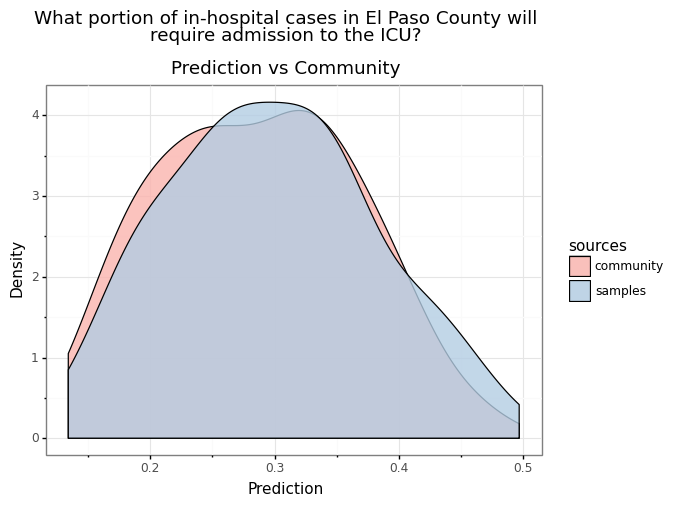

In [47]:
@question(4155, community_weight=0.7)
def frac_patients_icu():
    """
    What portion of in-hospital cases in El Paso County will require admission
    to the ICU?

    Following @katifish's approach:
    https://pandemic.metaculus.com/questions/4155/#comment-28054

    TODO: Add others from katifish comment
    """
    alpha = 0.1 # Rescaling counts becase we're more uncertain than implied by counts
    return ergo.random_choice([
      ergo.beta_from_hits(alpha * 121, alpha * 508),
      ergo.beta_from_hits(alpha * 181, alpha * 507),
    ])
plot_question(frac_patients_icu)

,count,mean,std,min,25%,50%,75%,max
frac_patients_icu,138.0,0.29,0.09,0.02,0.22,0.29,0.34,0.60
frac_patients_invasive,200.0,0.15,0.07,0.01,0.11,0.15,0.18,0.64


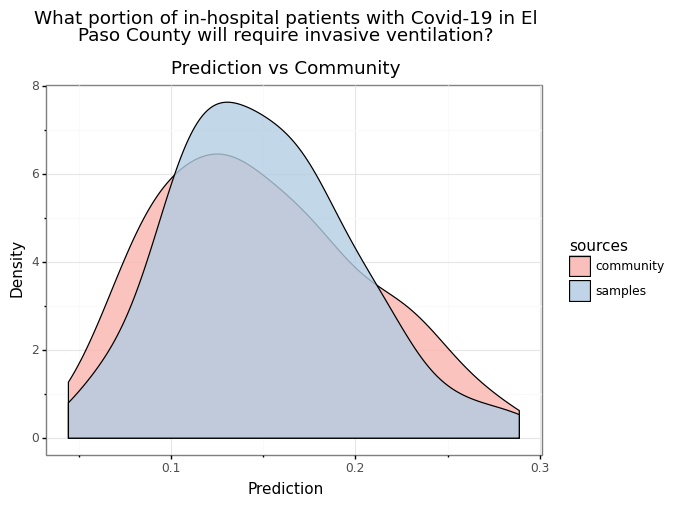

In [48]:
@question(4154, community_weight=0.3)
def frac_patients_invasive():
    """
    What portion of in-hospital patients with Covid-19 in El Paso County will
    require invasive ventilation?

    Following @PabloStafforini's indirect estimation approach:
    https://pandemic.metaculus.com/questions/4154/#comment-28155

    TODO:
    - Combine with direct estimate
      direct_estimate = ergo.beta_from_hits(0.1 * 130, 0.1 * 393)
    """
    return frac_patients_icu() * frac_icu_ventilation()
plot_question(frac_patients_invasive)

,count,mean,std,min,25%,50%,75%,max
peak_infection_date,141.0,24.65,6.20,14.00,23.0,25.00,25.00,62.00
max_30d_hospital_confirmed_for_peak,200.0,150.38,440.54,10.97,65.0,74.94,99.51,4922.38


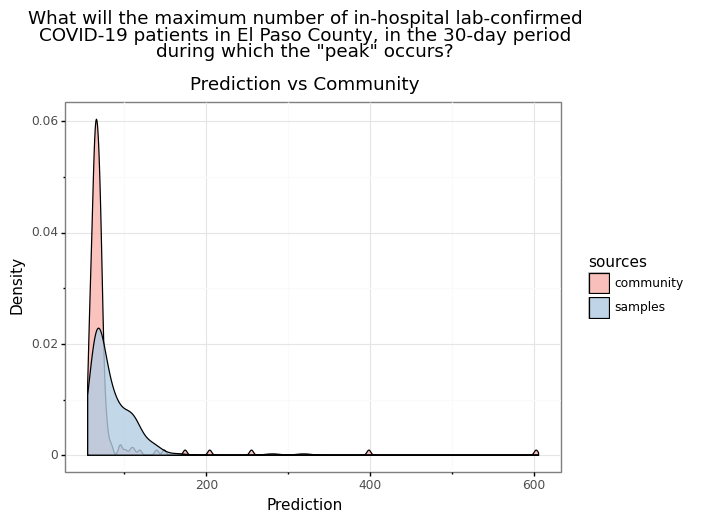

In [49]:
@question(4153, community_weight=0.3)
def max_30d_hospital_confirmed_for_peak():
    """
    What will the maximum number of in-hospital lab-confirmed COVID-19 
    patients in El Paso County, in the 30-day period during which the "peak"
    occurs?
    """
    peak = peak_infection_date()
    days = daterange(peak - timedelta(15), peak + timedelta(15))
    return max(hospital_confirmed_for_date(day) for day in days)

plot_question(max_30d_hospital_confirmed_for_peak)

,count,mean,std,min,25%,50%,75%,max
peak_infection_date,151.0,24.99,5.25,15.00,25.0,25.00,25.00,61.00
max_30d_hospital_confirmed_for_peak,200.0,224.96,1271.05,5.19,65.0,74.07,99.69,13671.22


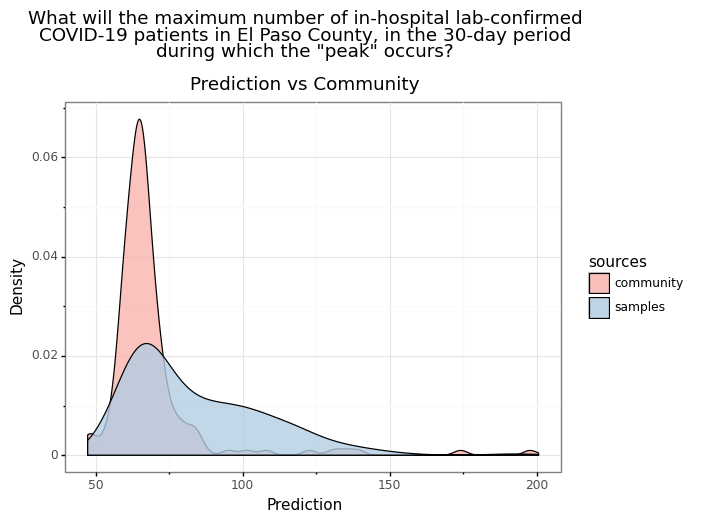

In [50]:
@question(4204)
def peak_icu_admissions():
    """
    How many patients with Covid-19 in El Paso County will be admitted to the
    ICU on the day when the number of hospital admissions of cases peak?

    Following @Tamay's approach:
    https://pandemic.metaculus.com/questions/4204/

    Alternative:    
    - peak = peak_hospitalizations_date()
    - return daily_icu_admissions(peak)

    FIXME: Admissions vs in-hospital patients unclear

    Not mixing in community since this is just the product of two other questions.    
    """
    max_patients = max_30d_hospital_confirmed_for_peak()
    return max_patients * frac_patients_icu()
plot_question(max_30d_hospital_confirmed_for_peak)

,count,mean,std,min,25%,50%,75%,max
peak_infection_date,139.0,25.25,6.26,14.00,24.00,25.00,25.00,84.00
frac_patients_icu,200.0,0.31,0.10,0.02,0.24,0.31,0.36,0.69
max_30d_hospital_confirmed_for_peak,200.0,165.08,1185.91,1.36,65.00,69.89,90.23,16846.22
peak_icu_admissions,200.0,61.09,519.93,0.66,17.58,21.87,29.13,7375.46
peak_invasive_ventilation,200.0,31.96,276.54,0.35,8.85,11.22,15.18,3922.35


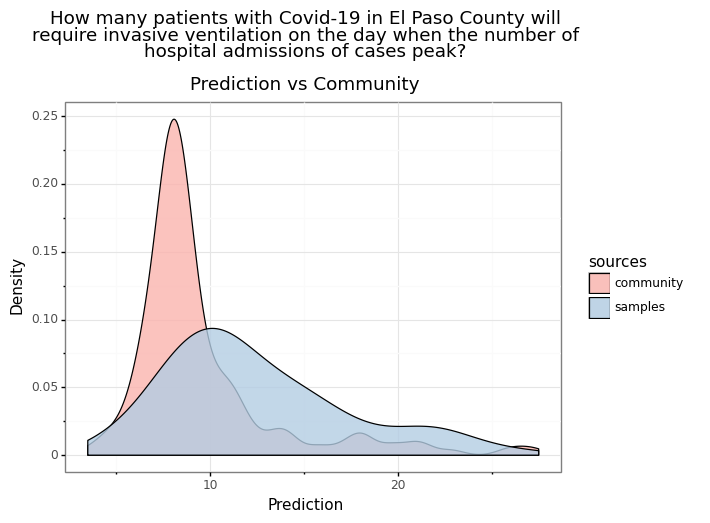

In [58]:
@question(4201)
def peak_invasive_ventilation():
    """
    How many patients with Covid-19 in El Paso County will require invasive 
    ventilation on the day when the number of hospital admissions of cases 
    peak?

    Following @Tamay's approach:
    https://pandemic.metaculus.com/questions/4201/#comment-28004

    Not mixing in community since this is just the product of two other questions.
    """
    return frac_icu_ventilation() * peak_icu_admissions()

plot_question(peak_invasive_ventilation)

# Generate predictions for all questions

In [52]:
def model():
    clear_mem()
    for sampler in samplers.values():
        sampler()

samples = ergo.run(model, num_samples=2000)

summarize_question_samples(samples)

,count,mean,std,min,25%,50%,75%,max
peak_infection_date,2000.0,25.80,10.79,14.00,24.00,25.00,25.00,141.00
peak_infections,2000.0,79.95,300.95,0.00,47.00,70.14,74.00,6229.48
mean_infections_peak345,2000.0,43.78,203.19,0.00,21.76,24.56,29.19,3582.12
mean_infections_peak678,2000.0,53.78,280.89,0.00,16.29,21.58,30.84,3372.31
frac_patients_icu,2000.0,0.30,0.10,0.00,0.23,0.30,0.36,0.85
frac_patients_invasive,2000.0,0.16,0.07,0.00,0.11,0.15,0.19,0.83
max_30d_hospital_confirmed_for_peak,2000.0,204.10,1176.24,1.15,65.00,71.98,97.44,24214.78
peak_icu_admissions,2000.0,60.84,369.27,0.00,16.87,22.64,30.86,7951.12
peak_invasive_ventilation,2000.0,30.96,188.50,0.00,8.57,11.57,15.60,4043.79


# Compare predictions to community

This takes a while since we're fitting a mixture of logistic distributions to our samples before visualizing (and submitting) them.
These may look a little different from the plots below the questions above, because we've taken more samples from the distribution and we're fitting logistic distributions so we can submit them to metaculus

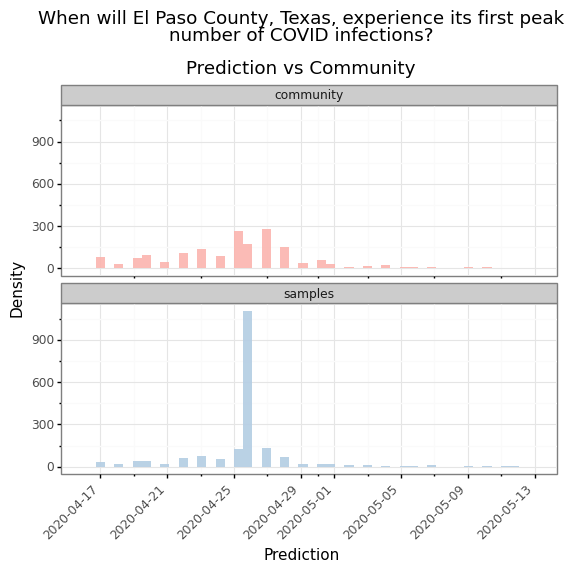

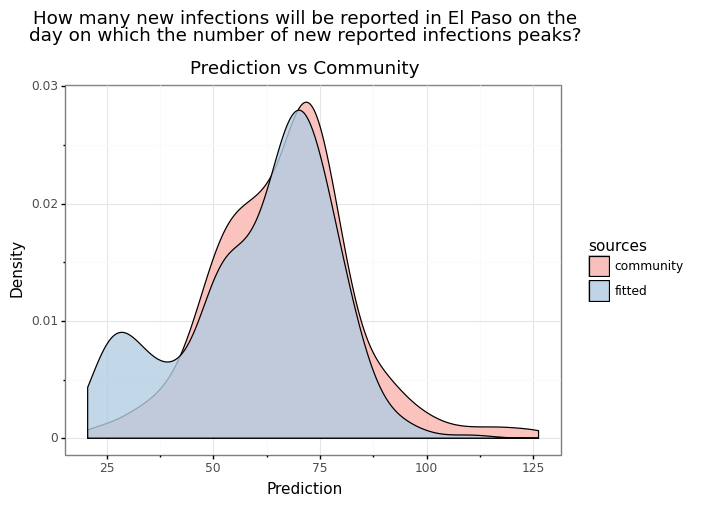

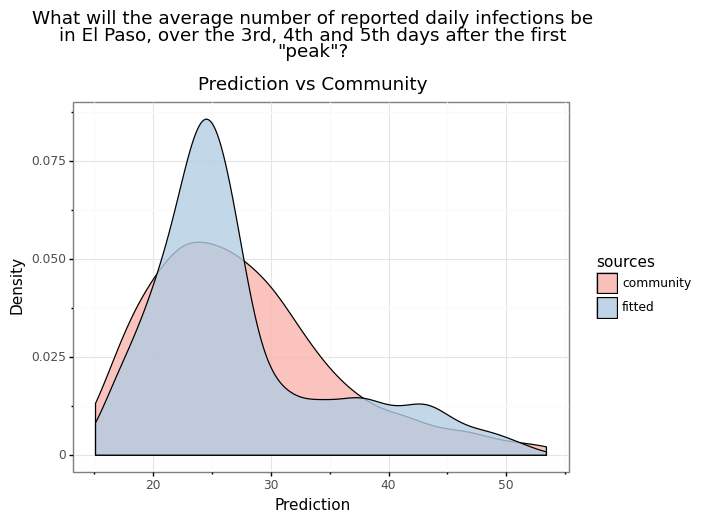

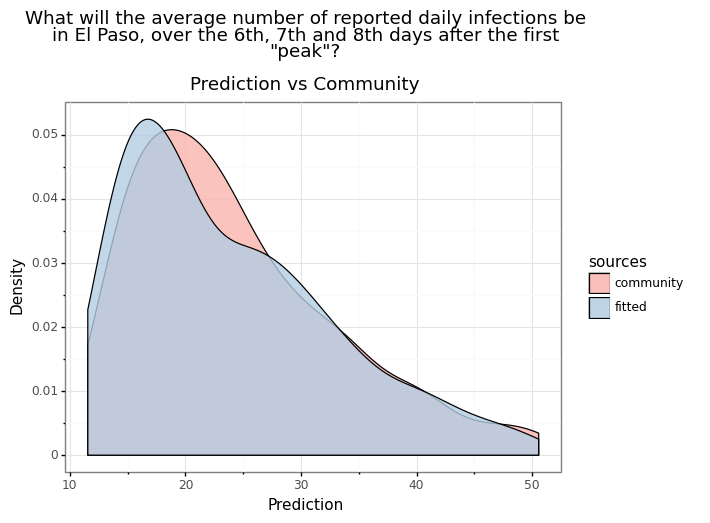

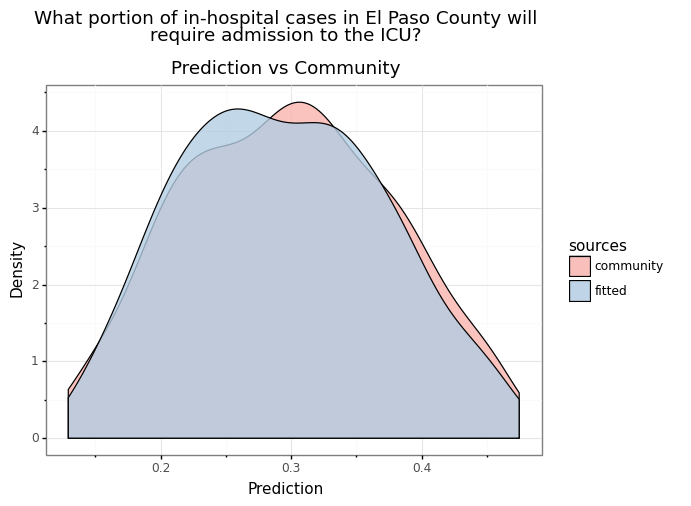

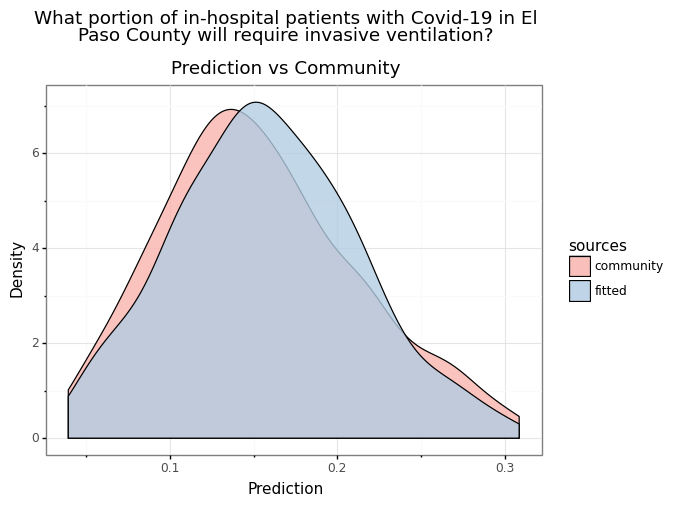

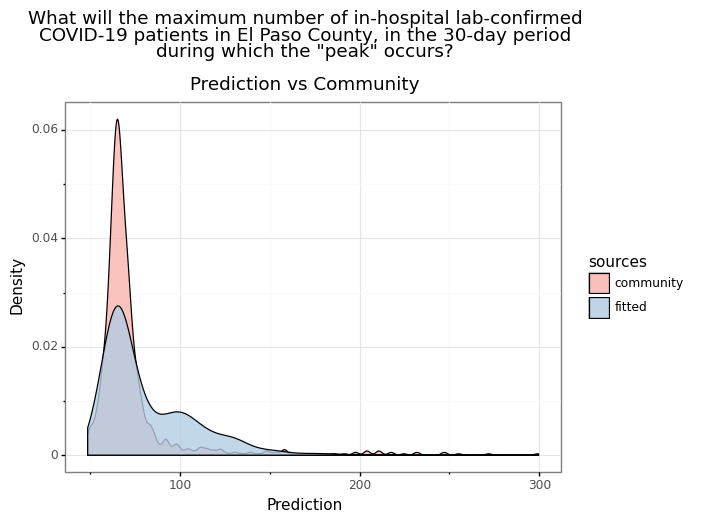

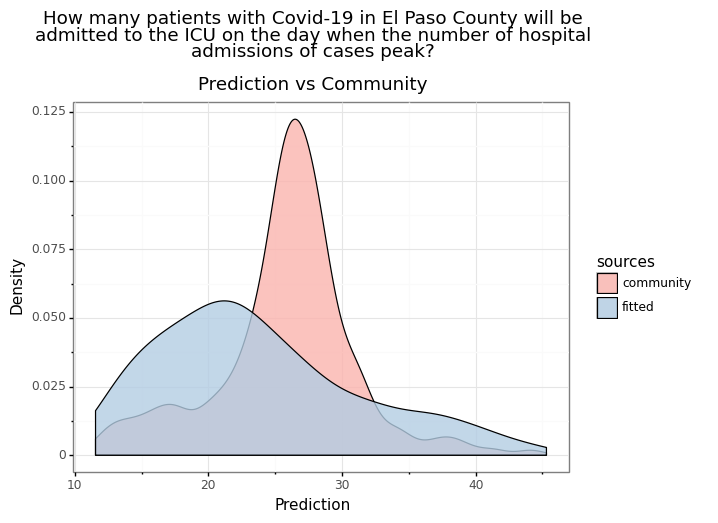

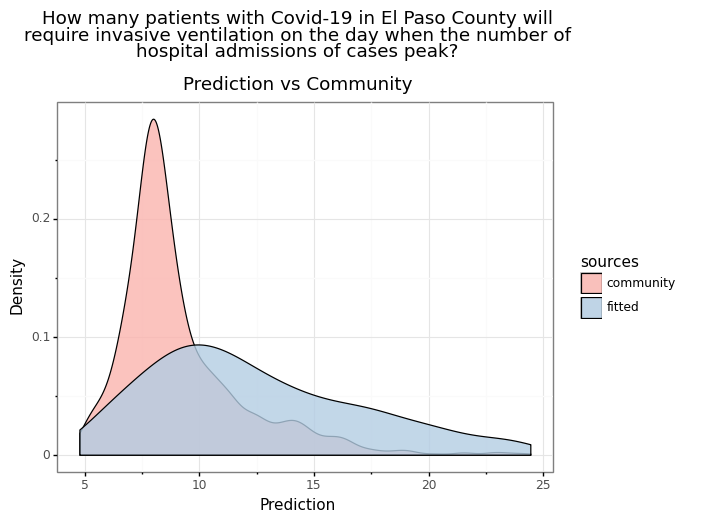

In [56]:
submissions = {}
for sampler in samplers.values():
    q = sampler.question

    q_samples = samples[sampler.__name__]

    if q.id == 4128: # Date question: Need to convert back to date from days (https://github.com/oughtinc/ergo/issues/144)
        q_samples = np.array([START_DATE + timedelta(s) for s in q_samples])

    if q.id in [4201, 4204, 4137, 4152, 4170, 4153]:
      # Clip extreme values for questions that we had issues fitting
      (sample_min, sample_max) = np.quantile(q_samples, [0.02, 0.98])
      q_samples = q_samples[(q_samples >= sample_min) & (q_samples <= sample_max)]

    submission = q.get_submission_from_samples(q_samples)
    submissions[q] = submission
    if q.id == 4128:
        # showing the fitted distribution doesn't work for this date question
        q.show_prediction(q_samples, plot="samples", show_community=True, percent_kept=0.9)
    else:
        q.show_prediction(q_samples, prediction=submission, plot="fitted", show_community=True, percent_kept=0.9)

In [0]:
# Should we submit this to Metaculus? If so, uncomment the following lines:
# for q, submission in submissions.items():  
#     print(q.submit(submission))